In [2]:
import sys
import os
import timm
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from torchvision import transforms
from sklearn.metrics import multilabel_confusion_matrix
import torch.nn as nn
from matplotlib.colors import ListedColormap

/cluster/home/taheeraa/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/taheeraa/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
src_dir = os.path.join("/cluster/home/taheeraa/code/BenchmarkTransformers"
                      )
if src_dir not in sys.path:
    sys.path.append(src_dir)
    
from dataloader import ChestXray14Dataset, build_transform_classification

In [4]:
path_to_labels = '/cluster/home/taheeraa/code/BenchmarkTransformers/dataset'
file_path_train = path_to_labels + '/Xray14_train_official.txt'
file_path_val = path_to_labels + '/Xray14_val_official.txt'
file_path_test = path_to_labels + '/Xray14_test_official.txt'

data_path = '/cluster/home/taheeraa/datasets/chestxray-14'
images_path = data_path + '/images'

num_workers = 4
pin_memory = False

num_labels = 14
batch_size = 32
learning_rate = 0.01
img_size = 224

labels = [
    "Atelectasis",
    "Cardiomegaly",
    "Effusion",
    "Infiltration",
    "Mass",
    "Nodule",
    "Pneumonia",
    "Pneumothorax",
    "Consolidation",
    "Edema",
    "Emphysema",
    "Fibrosis",
    "Pleural_Thickening",
    "Hernia"
]

In [5]:
# imagenet
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# cxr
normalize = transforms.Normalize(
    [0.5056, 0.5056, 0.5056], [0.252, 0.252, 0.252])

dataset_test = ChestXray14Dataset(images_path=images_path, 
  file_path=file_path_test,
  augment=build_transform_classification(
      normalize="chestx-ray",
      add_augment=True, 
      mode="test", 
      test_augment=True
  )
)

data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False,
                              num_workers=4, pin_memory=True)

Adding augmentations
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    TenCrop(size=(224, 224), vertical_flip=False)
    Lambda()
    Lambda()
)


In [6]:
def classifying_head(in_features: int, num_labels: int):
    return nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=in_features, out_features=128),
        nn.ReLU(),
        nn.BatchNorm1d(num_features=128),
        nn.Linear(128, num_labels),
    )

In [7]:
base = "/cluster/home/taheeraa/code/BenchmarkTransformers/models/classification/ChestXray14/05-change-classifier-head/"
pretrained_weights = base + "densenet121_imagenet_1k_adamw_32_bce_aug_class/model.pth.tar"

experiment_name = os.path.basename(os.path.dirname(pretrained_weights))
model_str = experiment_name.split('_')[0]
print(experiment_name, model_str)



if model_str =="alexnet":
    model = alexnet(weights="DEFAULT")
    model.classifier = nn.Linear(256*6*6, num_labels, bias=True)
elif model_str=="resnet50":
    model = timm.create_model(model_str, num_classes=num_labels, pretrained=True)
elif model_str == "densenet121":
    model = timm.create_model('densenet121', num_classes=num_labels, pretrained=True)
    model.classifier = classifying_head(1024, num_labels)
    
checkpoint = torch.load(pretrained_weights, map_location="cpu")
print(checkpoint.keys())

state_dict = checkpoint['state_dict']

msg = model.load_state_dict(state_dict, strict=False)
print('Loaded with msg: {}'.format(msg))

densenet121_imagenet_1k_adamw_32_bce_aug_class densenet121
dict_keys(['epoch', 'lossMIN', 'state_dict', 'optimizer', 'scheduler'])
Loaded with msg: <All keys matched successfully>


In [9]:
def test_classification(model, data_loader_test, device):
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)
    model.to(device)

    model.eval()

    y_test = torch.FloatTensor().cuda()
    p_test = torch.FloatTensor().cuda()

    with torch.no_grad():
        for i, (samples, targets) in enumerate(tqdm(data_loader_test)):
            targets = targets.cuda()
            y_test = torch.cat((y_test, targets), 0)

            if len(samples.size()) == 4:
                bs, c, h, w = samples.size()
                n_crops = 1
            elif len(samples.size()) == 5:
                bs, n_crops, c, h, w = samples.size()

            varInput = torch.autograd.Variable(
                samples.view(-1, c, h, w).cuda())

            out = model(varInput)
            out = torch.sigmoid(out)
            outMean = out.view(bs, n_crops, -1).mean(1)
            p_test = torch.cat((p_test, outMean.data), 0)

    return y_test, p_test

y_test, p_test = test_classification(model, data_loader_test, 'cuda')

100%|██████████| 800/800 [06:35<00:00,  2.02it/s]


In [10]:
threshold = 0.5
p_labels = (p_test > threshold).float()  # Use .float() if needed for further computations

In [ ]:
# Custom color map for the heatmaps using interpolation
custom_colors = ["#FFAFCC", "#FFC8DD","#FFC8DD","#FFC8DD","#FFC8DD","#FFC8DD","#FFC8DD","#FFC8DD", "#CDB4DB", "#CDB4DB", "#CDB4DB", "#CDB4DB","#CDB4DB","#CDB4DB","#CDB4DB","#CDB4DB","#CDB4DB","#CDB4DB","#CDB4DB", "#A2D2FF","#A2D2FF","#A2D2FF", "#BDE0FE", "#BDE0FE", "#BDE0FE", "#BDE0FE", "#EBF5FF", "#EBF5FF", "#EBF5FF"]
n_bins = 100  # Increase the number of bins to make the gradient smoother
cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors, N=n_bins)
# Compute confusion matrices for each class

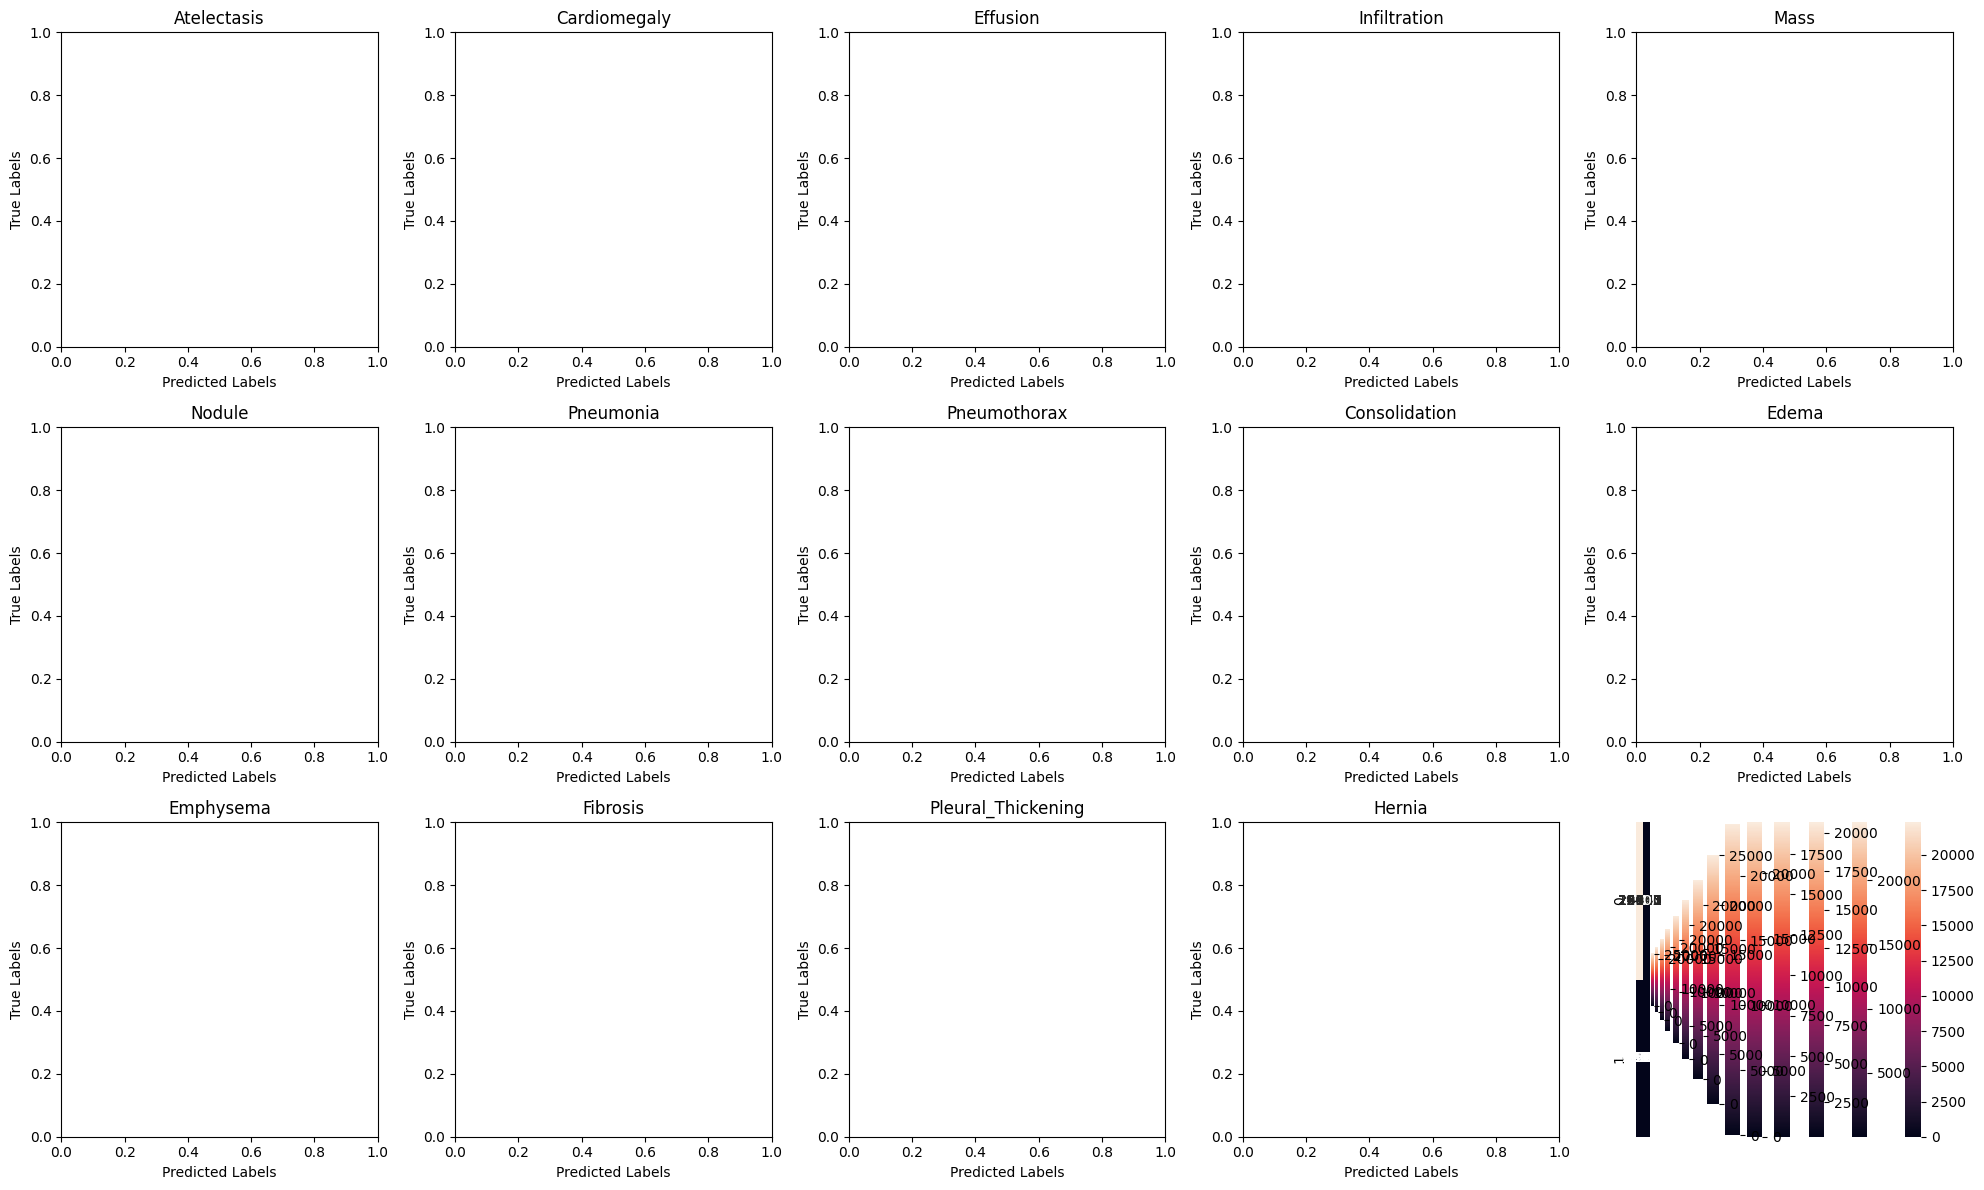

In [12]:
mcm = multilabel_confusion_matrix(y_test.cpu().numpy(), p_labels.cpu().numpy())

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))  # Adjust based on number of classes
axes = axes.flatten()
for i, cm in enumerate(mcm):
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d')
    ax.set_title(f'{labels[i]}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

plt.tight_layout()
plt.savefig("conf_matrix/all.png")